# Entorno

In [1]:
import torch
import librosa
import torchaudio
import numpy as np
from pydub import AudioSegment
from torch.utils.data import Dataset
from scripts.plot import plot_audio_sample
from scripts.extract import load_heart_noised_dict

# Relación de datos

In [2]:
heart_noised_dict = load_heart_noised_dict(
    clean_dir="data/heart_sound_test_small",
    noised_dir="data/heart_noised_test_small",
)

# Cómo suena?

In [3]:
test = "data/heart_sound_test_small/val/healthy/e00047.wav"

audio_clean = AudioSegment.from_file(test)
audio_noisy = AudioSegment.from_file(heart_noised_dict[test][-1])

In [4]:
audio_clean

In [5]:
audio_noisy

# Cómo se ve?

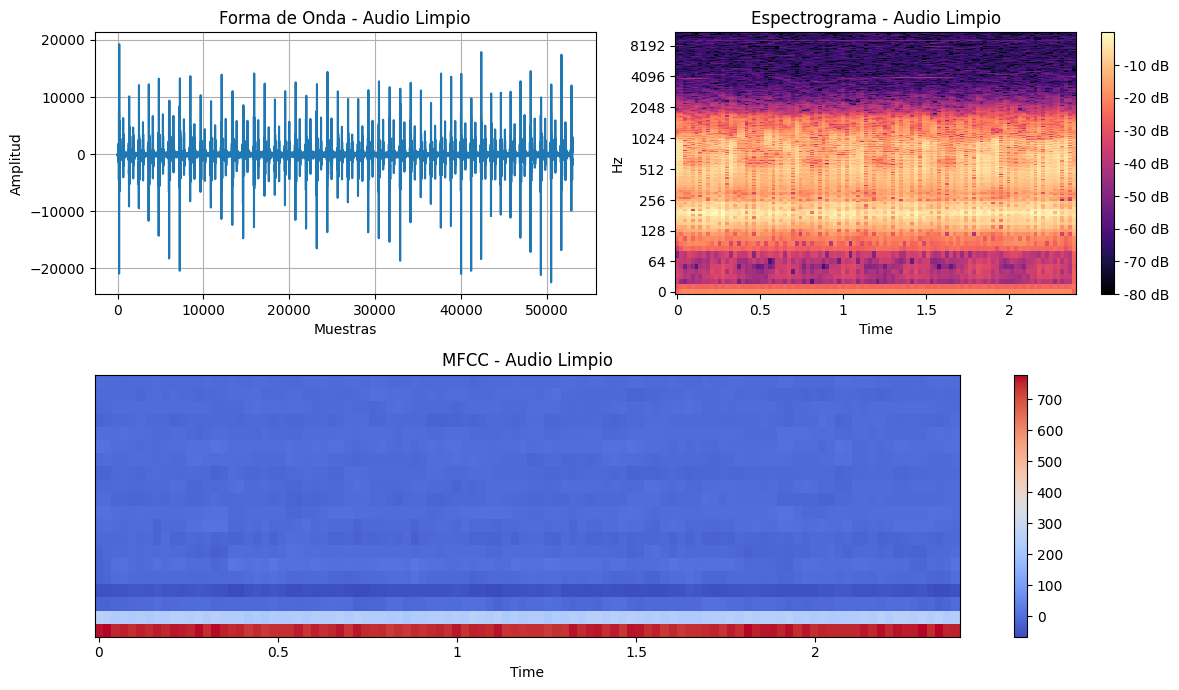

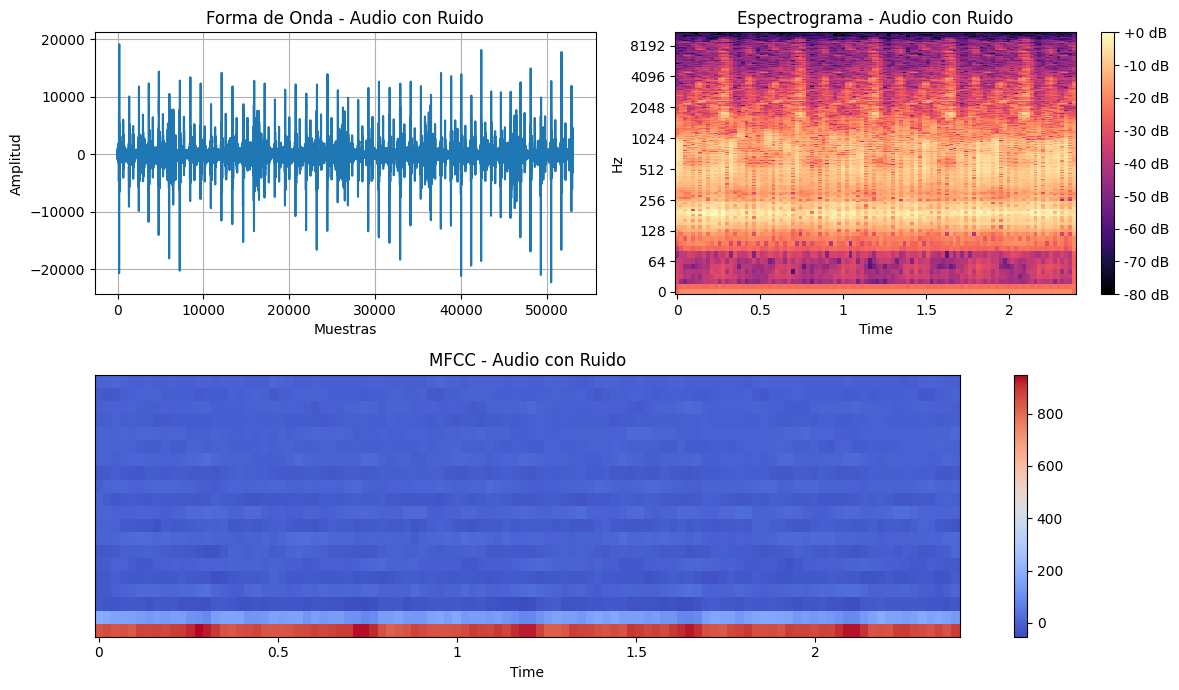

In [6]:
clean_array = np.array(audio_clean.get_array_of_samples())
noisy_array = np.array(audio_noisy.get_array_of_samples())

plot_audio_sample(clean_array, 'Audio Limpio')
plot_audio_sample(noisy_array, 'Audio con Ruido')

In [7]:
clean_array.shape, noisy_array.shape

((53056,), (53056,))

In [8]:
class CustomAudioDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        self.data_dict = data_dict
        self.transform = transform
        # Calcular la duración mínima de todos los audios
        self.min_duration = self.calculate_min_duration()

    def calculate_min_duration(self):
        # Inicializar min_duration con un valor grande
        min_duration = float('inf')

        # Recorrer los audios originales para encontrar la duración mínima
        for audio_path in self.data_dict.keys():
            _, num_frames = torchaudio.load(audio_path)
            min_duration = min(min_duration, num_frames)

        return min_duration
    
    def __len__(self):
        return len(self.data_dict)
    
    def adjust_audio_duration(self, audio, target_duration):
        """
        Ajusta la duración de un audio a la duración objetivo.

        Args:
            audio (torch.Tensor): Audio a ajustar.
            target_duration (int): Duración objetivo.

        Returns:
            torch.Tensor: Audio ajustado.
        """
        original_duration = audio.shape[-1]
        
        if original_duration <= target_duration:
            return audio
        
        # Truncar o recortar el audio al mínimo de las duraciones
        adjusted_audio = audio[..., :target_duration]

        return adjusted_audio
    
    def normalize_audio(self, audio):
        mean = audio.mean()
        std = audio.std()
        normalized = (audio - mean) / std
        normalized.unsqueeze_(dim=0)
        return normalized.reshape(1, 1, -1)

    def __getitem__(self, idx):
        clean_audio_path = list(self.data_dict.keys())[idx]
        clean_audio, sample_rate = torchaudio.load(clean_audio_path)

        clean_audio = self.normalize_audio(clean_audio)
        clean_audio = self.adjust_audio_duration(clean_audio, self.min_duration)

        noisy_audios = []
        noisy_audio_paths = self.data_dict[clean_audio_path]

        for noisy_audio_path in noisy_audio_paths:
            noisy_audio = AudioSegment.from_file(noisy_audio_path)
            noisy_audio = torch.Tensor(noisy_audio.get_array_of_samples())

            noisy_audio = self.normalize_audio(noisy_audio)
            noisy_audio = self.adjust_audio_duration(noisy_audio, self.min_duration)

            noisy_audios.append(noisy_audio)

        noisy_audios = torch.stack(noisy_audios)

        if self.transform:
            clean_audio = self.transform(clean_audio, sample_rate)

            noisy_transformed = []
            for noisy_audio in noisy_audios:
                noisy_audio = self.transform(noisy_audio, sample_rate)
                noisy_transformed.append(noisy_audio)

            noisy_audios = torch.stack(noisy_transformed)

        return clean_audio, noisy_audios.squeeze(dim=1)

In [9]:
from scripts.transform import spec_n_mfcc

cad = CustomAudioDataset(heart_noised_dict, spec_n_mfcc)
cad[5][0].shape, cad[5][1].shape

/Users/efrainflores/.local/share/virtualenvs/cora_cleaner-eXlQ0b7N/lib/python3.11/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2000
  warnings.warn(


(torch.Size([1, 1, 3716]), torch.Size([5, 1, 3716]))